In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dtf = pd.read_csv('examiner_new.csv', index_col = 0)


In [2]:
dataframe = pd.read_csv('newest_data.csv', index_col = 0)

In [3]:
dataframe = dataframe.drop(['citation','cpc','inventor','assignee','examiners','cpc_01','cpc_03','cites_01', 'x_coor','y_coor','z_coor'], axis=1)

In [4]:
dataframe = dataframe.drop(['cpc_02','joined_all'],axis=1)

In [5]:
dataframe = dataframe.drop(['grant_date'],axis=1)

In [ ]:
series = dataframe.joined_cleaned

In [ ]:
cat_series = series.str.cat(sep=' ')

In [ ]:
words = result['des'][0].split(' ')

In [ ]:
from collections import Counter

a = Counter(words).keys() # equals to list(set(words))
b = Counter(words).values() # counts the elements' frequency

In [ ]:
c= Counter(words)
sred = sorted(c.items(), key=lambda value: value[1])
sred

# Getting the data together. Dataframe: row: integer indices and columns: [patent number, title, abstract, claims, description]

In [ ]:
new_dataframe = dataframe.drop(['joined_cleaned'],axis=1)
#new_dataframe = new_dataframe.drop(['description'],axis=1)
new_dataframe

# Extracting all the descriptions for patents


In [ ]:
import zipfile
archive = zipfile.ZipFile('patent_des.zip', 'r')
op = pd.read_csv(archive.open('patent_des.tsv'), sep='\t', header=None, encoding = "ISO-8859-1")
#eg=op.iloc[1,1]
#freq_eg = pd.Series(' '.join().split()).value_counts()[:20]
op.columns=['patnum','des']
op = op.drop(0)
#series_description = op['des'].str.lower()
op = op.dropna()
op.columns=['pnt','des']



result = pd.concat([new_dataframe, op], axis=1, sort=False)


result['des'] = result['des'].shift(-1)
result = result.drop(['pnt'],axis=1)

result=result.dropna()
result['abstract']=result['abstract'].str.lower()
result['claims']=result['claims'].str.lower()
result['des']=result['des'].str.lower()

# Concatenating all columns into one training set X_train[...] = (titles+abstract+claims+description)

In [30]:
s = new_dataframe.iloc[0,1:4]
s1= s.str.cat(sep='')
s1

all_strings = [result.iloc[i,1:5].str.cat(sep=' ') for i in range(0,12969)]

In [31]:
dr = pd.DataFrame(all_strings,columns=['joined'])

# AUTOMATE KEYWORD GENERATION


In [ ]:
#dataset= dataframe.drop(['title','claims','abstract'],axis=1)

In [34]:
dr['WordCount'] = [len(s) for s in dr['joined']] #finding word cout

# most common words
# dr=dataset

In [ ]:

freq = pd.Series(' '.join(dr['joined']).split()).value_counts()[:20]
freq

# Identify uncommon words

In [ ]:

freq1 =  pd.Series(' '.join(dr['joined']).split()).value_counts()[-20:]
freq1

# stemming and lemmatization
# Libraries for text preprocessing

In [35]:

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stem = PorterStemmer()

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prithiv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/prithiv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Creating a list of stop words and adding custom stopwords

In [36]:

stop_words = set(stopwords.words("english"))

## Creating a list of custom stopwords

In [37]:

new_words = ["invention","configuration","applications","background","field","description","","using", "show","claim","claimed","method","second","first","comprising", "result", "large", "also", "iv", "one", "two", "would","time","new", "previously", "shown","comprise","sub","computer","system"]
stop_words = stop_words.union(new_words)


# Carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [38]:

corpus = []
for i in range(0, 12969):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dr['joined'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)


# Word cloud

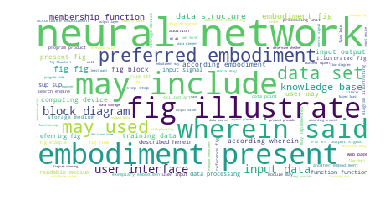

In [39]:

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

# Fit to X

In [72]:
import time
start = time.time()
#fit
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)
end = time.time()
print(end - start)

11771.391273021698


In [73]:
list(cv.vocabulary_.keys())[:10]

['distributed',
 'management',
 'embedded',
 'agent',
 'enterprise',
 'mobile',
 'disclosed',
 'related',
 'retrieved',
 'storage']

In [101]:
with open('train', 'wb') as f1:
    pickle.dump([X], f1)
#saving the training variable

# n-grams, bi-grams, tri-grams
# Most frequently occuring words

In [46]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

# Convert most freq words to dataframe for plotting bar plot

[Text(0,0,'data'),
 Text(0,0,'may'),
 Text(0,0,'fig'),
 Text(0,0,'user'),
 Text(0,0,'value'),
 Text(0,0,'example'),
 Text(0,0,'set'),
 Text(0,0,'input'),
 Text(0,0,'information'),
 Text(0,0,'embodiment'),
 Text(0,0,'said'),
 Text(0,0,'network'),
 Text(0,0,'rule'),
 Text(0,0,'function'),
 Text(0,0,'step'),
 Text(0,0,'output'),
 Text(0,0,'process'),
 Text(0,0,'model'),
 Text(0,0,'based'),
 Text(0,0,'device')]

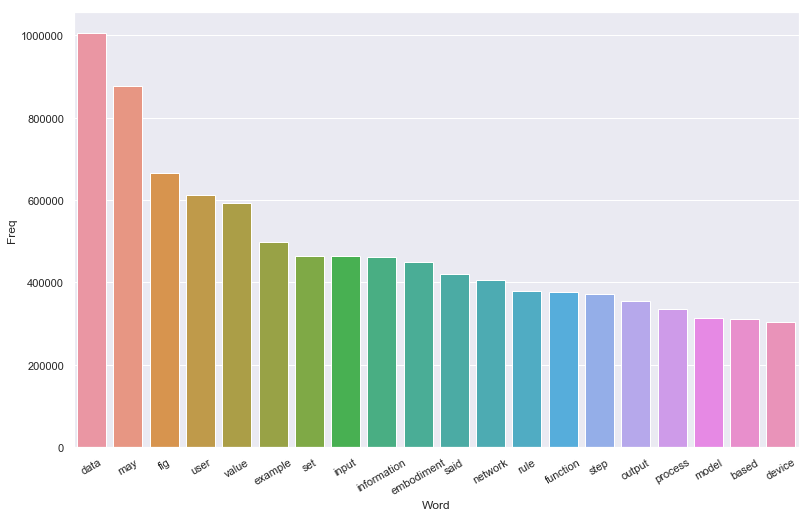

In [47]:

top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

# Most frequently occuring Bi-grams

                 Bi-gram    Freq
0         neural network  134244
1              time time  124413
2            may include   76899
3     embodiment present   62521
4               fig show   57125
5        fig illustrates   56648
6           wherein said   54329
7   preferred embodiment   50780
8               may used   45775
9               data set   43648
10         block diagram   41001
11        user interface   39713
12            input data   39351
13        knowledge base   36389
14   membership function   33975
15               fig fig   33733
16        data structure   33151
17        embodiment fig   31686
18  according embodiment   31466
19         training data   29818


[Text(0,0,'neural network'),
 Text(0,0,'time time'),
 Text(0,0,'may include'),
 Text(0,0,'embodiment present'),
 Text(0,0,'fig show'),
 Text(0,0,'fig illustrates'),
 Text(0,0,'wherein said'),
 Text(0,0,'preferred embodiment'),
 Text(0,0,'may used'),
 Text(0,0,'data set'),
 Text(0,0,'block diagram'),
 Text(0,0,'user interface'),
 Text(0,0,'input data'),
 Text(0,0,'knowledge base'),
 Text(0,0,'membership function'),
 Text(0,0,'fig fig'),
 Text(0,0,'data structure'),
 Text(0,0,'embodiment fig'),
 Text(0,0,'according embodiment'),
 Text(0,0,'training data')]

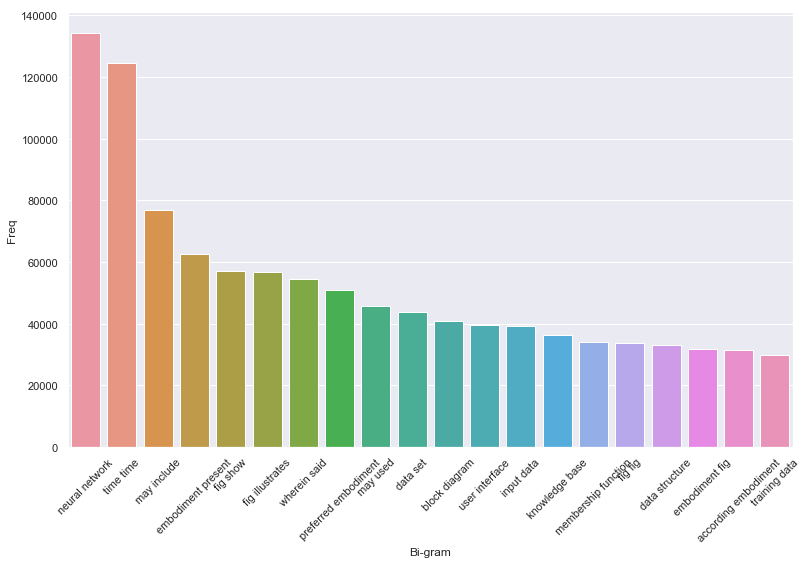

In [48]:

def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)


# Most frequently occuring Tri-grams

                           Tri-gram   Freq
0                    time time time  74961
1                 fig block diagram  23841
2            embodiment present fig  15311
3                function time time  12752
4                time time function  12716
5                time function time  11429
6           readable storage medium  10879
7            according wherein said  10777
8                     time time equ  10492
9                       sup sup sup   9929
10     according embodiment present   9709
11  accordance preferred embodiment   9580
12                     di elect con   9492
13        artificial neural network   8699
14                 based least part   8604
15    accordance embodiment present   8546
16                   fig flow chart   8259
17                 fig flow diagram   8172
18         graphical user interface   7802
19            subjective user state   7568


[Text(0,0,'time time time'),
 Text(0,0,'fig block diagram'),
 Text(0,0,'embodiment present fig'),
 Text(0,0,'function time time'),
 Text(0,0,'time time function'),
 Text(0,0,'time function time'),
 Text(0,0,'readable storage medium'),
 Text(0,0,'according wherein said'),
 Text(0,0,'time time equ'),
 Text(0,0,'sup sup sup'),
 Text(0,0,'according embodiment present'),
 Text(0,0,'accordance preferred embodiment'),
 Text(0,0,'di elect con'),
 Text(0,0,'artificial neural network'),
 Text(0,0,'based least part'),
 Text(0,0,'accordance embodiment present'),
 Text(0,0,'fig flow chart'),
 Text(0,0,'fig flow diagram'),
 Text(0,0,'graphical user interface'),
 Text(0,0,'subjective user state')]

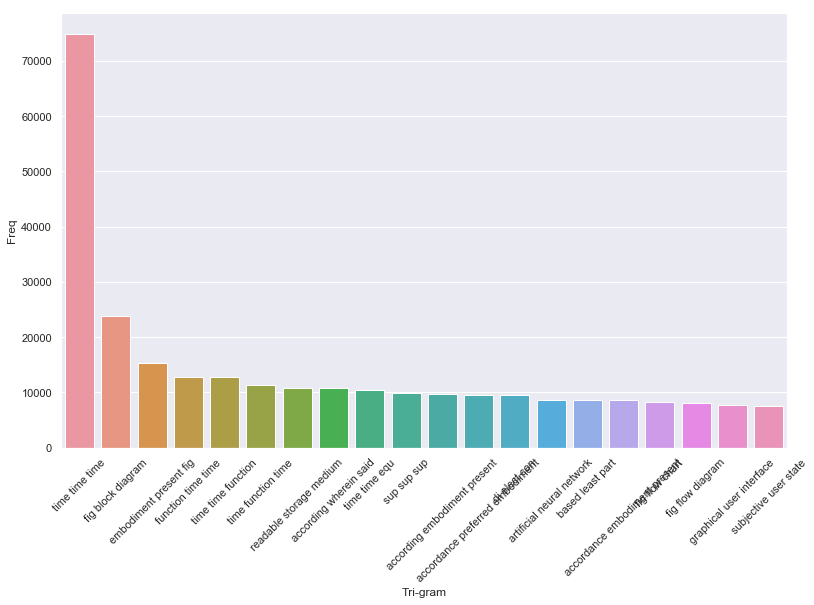

In [49]:

def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [77]:
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 


In [88]:
def keyword_predict(patent):
    # fetch document for which keywords needs to be extracted
    doc=corpus[patent]

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    #Function for sorting tf_idf in descending order

    def sort_coo(coo_matrix):
        tuples = zip(coo_matrix.col, coo_matrix.data)
        return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

    def extract_topn_from_vector(feature_names, sorted_items, topn=10):
        """get the feature names and tf-idf score of top n items"""

        #use only topn items from vector
        sorted_items = sorted_items[:topn]

        score_vals = []
        feature_vals = []

        # word index and corresponding tf-idf score
        for idx, score in sorted_items:

            #keep track of feature name and its corresponding score
            score_vals.append(round(score, 3))
            feature_vals.append(feature_names[idx])

        #create a tuples of feature,score
        #results = zip(feature_vals,score_vals)
        results= {}
        for idx in range(len(feature_vals)):
            results[feature_vals[idx]]=score_vals[idx]

        return results
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)

    # now print the results
    key = []
    for k in keywords:
        key.append(k)
    return key

In [90]:
keywords_all_patents = [keyword_predict(i) for i in range(0, 12969)]

In [ ]:
keywords_all_patents

In [93]:
result['keywords'] = keywords_all_patents

In [99]:
import pickle

with open('all_keywords', 'wb') as f:
    pickle.dump([keywords_all_patents], f)


#with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
    #obj0, obj1, obj2 = pickle.load(f)

# Save

In [103]:
result.to_csv('predicted_keywords.csv')
    
    

In [104]:
t = pd.read_csv('predicted_keywords.csv')

In [105]:
t

,Unnamed: 0,patnum,title,abstract,claims,des,keywords
0,0,9043460,Distributed management with embedded agents in...,distributed mobile device management including...,"what is claimed is:1. a method, comprising: r...",background of the invention many mobile devic...,"['management', 'agent', 'agent may', 'related ..."
1,1,9043350,Providing topic based search guidance,"methods, systems, and computer-readable media ...",the invention claimed is:1. one or more compu...,background users are able to locate relevant ...,"['search', 'topic', 'set search', 'query', 'pr..."
2,2,9043337,Data mining and model generation using an in-d...,embodiments are described for a system and met...,what is claimed is:1. a method of generating ...,field of the invention one or more implementa...,"['analytic', 'data source', 'flow', 'operator'..."
3,3,9043273,Method and apparatus for declarative data ware...,a data warehouse is constructed using the rela...,what is claimed is:1. a method to create a da...,field of the invention the present invention ...,"['data warehouse', 'warehouse', 'dimension', '..."
4,4,9043265,Methods and systems for constructing intellige...,a computer implemented method of constructing ...,i claim:1. a computer implemented method of c...,background of the invention the present inven...,"['glossary', 'symbol', 'formal', 'distinction'..."
5,5,9043264,Scanning data streams in real-time against lar...,embodiments of the disclosure include a method...,the invention claimed is:1. a method for part...,background the present invention relates to t...,"['transition rule', 'rule', 'transition', 'dfa..."
6,6,9043263,Systems and methods for control reliability op...,"in one embodiment, a system includes a data co...",the invention claimed is:1. a turbine system ...,background of the invention the subject matte...,"['health', 'advisor', 'assessment', 'controlle..."
7,7,9043262,"Information providing apparatus for vehicle, a...",an information providing apparatus for vehicle...,the invention claimed is:1. an information pr...,technical field the present invention relates...,"['power consumption', 'consumption', 'battery'..."
8,8,9043261,"Latent variable model estimation apparatus, an...",to provide a latent variable model estimation ...,what is claimed is:1. a latent variable model...,background of the invention 1. field of the ...,"['latent', 'latent variable', 'probability', '..."
9,9,9043260,Method and apparatus for contextual content su...,an approach is provided for contextual content...,what is claimed is:1. a method comprising fac...,"background wireless (e.g., cellular) service ...","['content item', 'content', 'contextual', 'rec..."
